In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/instagram-user-growth-by-country/instagram-users-by-country-2024.csv


In [27]:
!pip install pycountry_convert


# **Importing Libraries**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import r2_score,accuracy_score

In [29]:
data = pd.read_csv('/kaggle/input/instagram-user-growth-by-country/instagram-users-by-country-2024.csv')
data.head()

,country,InstagramUsers_2024,InstagramUsers_PctFemale_2024,InstagramUsers_PctMale_2024,InstagramUsers2023
0,India,392465000.0,33.1,66.9,229600000
1,United States,172606200.0,55.4,44.6,143400000
2,Indonesia,90183200.0,54.2,45.8,89150000
3,Pakistan,18593301.0,35.1,64.9,12950000
4,Nigeria,12635900.0,46.5,53.5,7100000


In [30]:
data.country.count()

226

In [31]:
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return "Other"


data['continent'] = data['country'].apply(country_to_continent)
data.head()

,country,InstagramUsers_2024,InstagramUsers_PctFemale_2024,InstagramUsers_PctMale_2024,InstagramUsers2023,continent
0,India,392465000.0,33.1,66.9,229600000,Asia
1,United States,172606200.0,55.4,44.6,143400000,North America
2,Indonesia,90183200.0,54.2,45.8,89150000,Asia
3,Pakistan,18593301.0,35.1,64.9,12950000,Asia
4,Nigeria,12635900.0,46.5,53.5,7100000,Africa


In [32]:
data_grouped = data.groupby('continent')[['InstagramUsers2023','InstagramUsers_2024']].sum().reset_index()

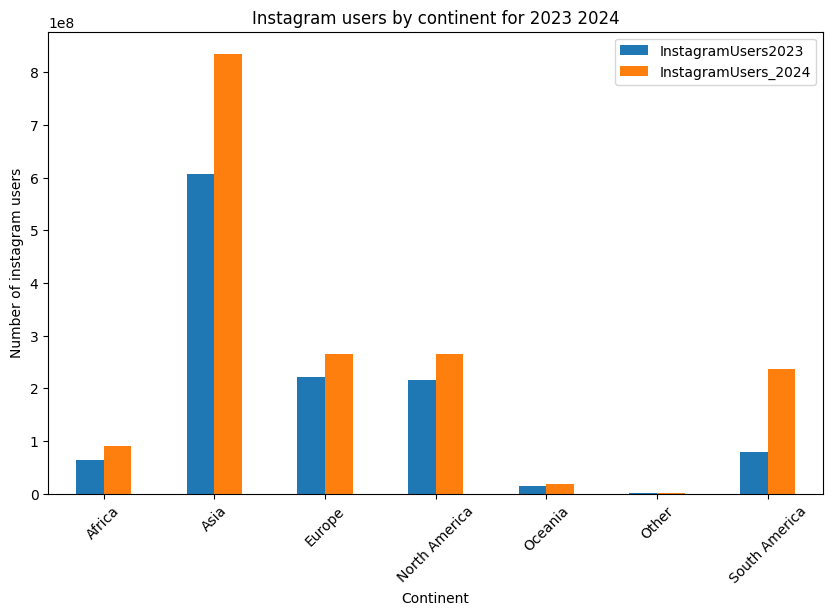

In [33]:
def plot_for_2023_2024(data_grouped):
    data_grouped.plot(x='continent',kind='bar',figsize=(10,6))
    plt.title("Instagram users by continent for 2023 2024")
    plt.xlabel("Continent")
    plt.ylabel("Number of instagram users")
    plt.xticks(rotation=45)
    plt.legend(["InstagramUsers2023","InstagramUsers_2024"])
    plt.show()
    
    
plot_for_2023_2024(data_grouped)

In [34]:
data_grouped['Growth_Avg'] = (data_grouped["InstagramUsers_2024"]/data_grouped["InstagramUsers2023"])-1
data_grouped[['continent','Growth_Avg']].sort_values('Growth_Avg',ascending=False)

,continent,Growth_Avg
6,South America,2.018930
0,Africa,0.409719
1,Asia,0.376467
3,North America,0.232357
4,Oceania,0.220935
2,Europe,0.193205
5,Other,0.075141


# Instagram users sex by continent

In [35]:
def plot_by_instagram_users_sex(data):
    data_grouped_sex = data.groupby('continent')[['InstagramUsers_PctMale_2024','InstagramUsers_PctFemale_2024']].sum().reset_index()
    data_grouped_sex.plot(x='continent',kind='bar',figsize=(10,6))
    plt.title('Instagram users by sex for 2024')
    plt.xlabel('Continent')
    plt.ylabel('Percentage of Instagram users')
    plt.xticks(rotation=45)
    plt.legend(["Instagram_PctMale_2024","Instagram_PctFemale_2024"])
    plt.show()

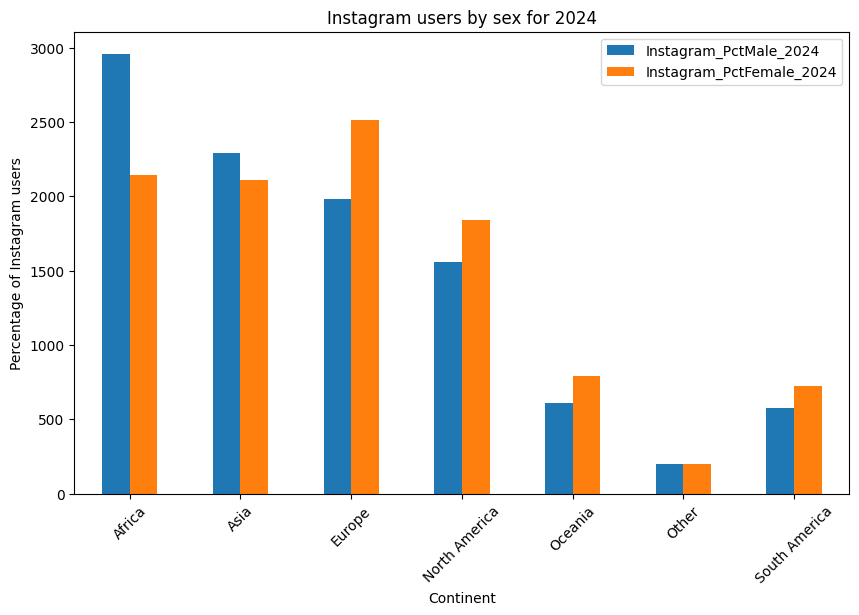

In [36]:
plot_by_instagram_users_sex(data)

# Missing values

In [37]:
data.isnull().sum()

country                           0
InstagramUsers_2024              21
InstagramUsers_PctFemale_2024    21
InstagramUsers_PctMale_2024      21
InstagramUsers2023                0
continent                         0
dtype: int64

In [38]:
data.dropna(inplace=True)

In [39]:
data.isnull().sum()

country                          0
InstagramUsers_2024              0
InstagramUsers_PctFemale_2024    0
InstagramUsers_PctMale_2024      0
InstagramUsers2023               0
continent                        0
dtype: int64

In [40]:
data['Avg_Growth'] = (data['InstagramUsers_2024']/data["InstagramUsers2023"])-1
max_growth_thres = 2.018
data['Avg_Growth'] = data["Avg_Growth"].apply(lambda x: min(x,max_growth_thres))

In [41]:
data['Expected_InstagramUsers_2025'] = data['InstagramUsers_2024'] * (1 + data['Avg_Growth'])


# Splitting the data


In [42]:
data.head()

,country,InstagramUsers_2024,InstagramUsers_PctFemale_2024,InstagramUsers_PctMale_2024,InstagramUsers2023,continent,Avg_Growth,Expected_InstagramUsers_2025
0,India,392465000.0,33.1,66.9,229600000,Asia,0.709342,6.708570e+08
1,United States,172606200.0,55.4,44.6,143400000,North America,0.203669,2.077608e+08
2,Indonesia,90183200.0,54.2,45.8,89150000,Asia,0.011589,9.122837e+07
3,Pakistan,18593301.0,35.1,64.9,12950000,Asia,0.435776,2.669582e+07
4,Nigeria,12635900.0,46.5,53.5,7100000,Africa,0.779704,2.248816e+07


In [46]:
X = data.drop(columns=['Expected_InstagramUsers_2025','country','continent','Avg_Growth'])
y = data['Expected_InstagramUsers_2025']

In [48]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
print(X_train.shape)
print(X_test.shape)

(153, 4)
(52, 4)


# model building

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# evaluation function

In [50]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Model training

In [53]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost":xgb.XGBRegressor()
   
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1322019.2255
- Mean Absolute Error: 387077.4688
- R2 Score: 0.9996
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 288004.3078
- Mean Absolute Error: 216102.4129
- R2 Score: 0.9995


Lasso
Model performance for Training set
- Root Mean Squared Error: 1322019.2255
- Mean Absolute Error: 387077.4182
- R2 Score: 0.9996
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 288016.1414
- Mean Absolute Error: 216119.5175
- R2 Score: 0.9995


Ridge
Model performance for Training set
- Root Mean Squared Error: 1322019.2255
- Mean Absolute Error: 387074.5127
- R2 Score: 0.9996
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 288000.0998
- Mean Absolute Error: 216097.7819
- R2 Score: 0.9995


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 38648729.4476
- 

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.97281e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 21731662.1640
- Mean Absolute Error: 2997042.7840
- R2 Score: 0.8926
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1295914.3497
- Mean Absolute Error: 572615.2454
- R2 Score: 0.9901


XGBoost
Model performance for Training set
- Root Mean Squared Error: 2654.3163
- Mean Absolute Error: 1836.6434
- R2 Score: 1.0000
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 909960.4199
- Mean Absolute Error: 450501.8873
- R2 Score: 0.9951




**selecting the model with best r2_score**

In [54]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)

In [55]:
r2_score = r2_score(y_test,y_pred)
print(r2_score)

0.9995109812551627


In [56]:
y_pred_all = lin_reg.predict(X)
data['predicted_InstagramUsers_2025'] = y_pred_all

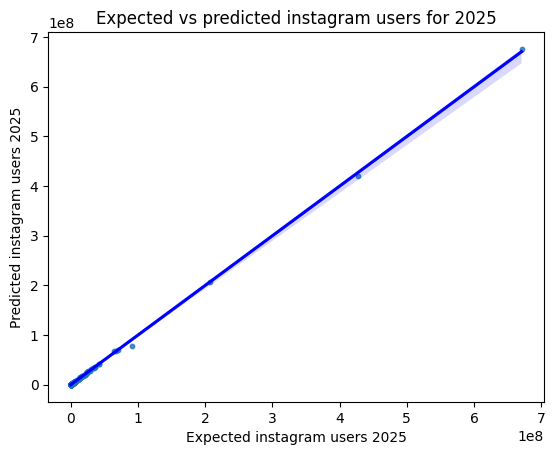

In [60]:
def pred_true_plot(data):
    sns.regplot(x=data['Expected_InstagramUsers_2025'],y=data["predicted_InstagramUsers_2025"],scatter_kws={'s':10},line_kws={'color':'blue'})
    plt.xlabel("Expected instagram users 2025")
    plt.ylabel("Predicted instagram users 2025")
    plt.title("Expected vs predicted instagram users for 2025")
    plt.show()
pred_true_plot(data)

# Final plotting of 2023,2024, true and pred 2025

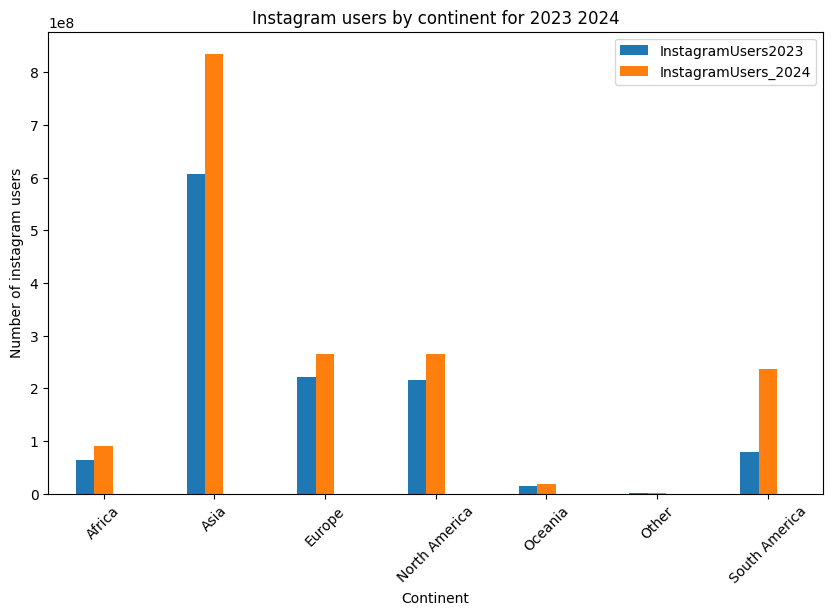

In [62]:
def plot_for_2023_2024_2025(data):
    data_grouped_exp = data.groupby('continent')[['InstagramUsers2023','InstagramUsers_2024','Expected_InstagramUsers_2025','predicted_InstagramUsers_2025']].sum().reset_index()
    data_grouped.plot(x='continent',kind='bar',figsize=(10,6))
    plt.title("Instagram users by continent for 2023 2024")
    plt.xlabel("Continent")
    plt.ylabel("Number of instagram users")
    plt.xticks(rotation=45)
    plt.legend(["InstagramUsers2023","InstagramUsers_2024"])
    plt.show()
    
    
plot_for_2023_2024_2025(data)